In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import k3d
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sys
import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-47pefo9n because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import torch
from torch.utils.data import DataLoader

In [4]:
from sharpf.data.datasets.sharpf_io import PointCloudIO, DepthMapIO
from sharpf.utils.abc_utils.hdf5.dataset import LotsOfHdf5Files, Hdf5File
from sharpf.utils.abc_utils.torch import *
from sharpf.utils.plotting import display_depth_sharpness

from sharpf.utils.camera_utils.camera_pose import camera_to_display, CameraPose
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.utils.py_utils.config import load_func_from_config

In [17]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 0.5

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [7]:
!ls /logs/images_with_noise/

abc_0000_12_13_0.0025.hdf5  abc_0000_12_13_0.01.hdf5  abc_0000_12_13_0.04.hdf5
abc_0000_12_13_0.005.hdf5   abc_0000_12_13_0.02.hdf5  abc_0000_12_13_0.08.hdf5


## Creating the dataset and observing it

In [8]:
# transform = CompositeSharpnessTransform([
#     TypeCast(torch.float32, torch.float32),
#     Center(),
#     NormalizeL2(),
#     Random3DRotation(),
# #     RandomSubsamplePoints(1024, 3.0),
# ])

In [144]:
# hdf5_input_dir = '/logs/points'
data_label = 'image'
target_label = 'distances'
# labels = ['directions', 'distances', 'has_sharp', 
#           'item_id', 'normals', 'num_sharp_curves', 
#           'num_surfaces', 'orig_face_indexes', 'orig_vert_indices', 'points']
labels = '*'
# labels = ['points',
#           'num_sharp_curves', 
#           'num_surfaces',
#           'camera_pose']

# dataset = LotsOfHdf5Files(
#         data_dir=hdf5_input_dir,
#         io=DepthIO,
#         data_label=data_label,
#         target_label=target_label,
#         labels=labels,
#         max_loaded_files=10)

dataset = Hdf5File(
    '/logs/images_with_noise/abc_0000_12_13_0.02.hdf5',
    io=DepthMapIO,
    data_label=data_label,
    target_label=target_label,
    labels='*',
    transform=None)
len(dataset)

1230

In [145]:
images = np.array([camera_to_display(dataset[idx]['image'].numpy())
                   for idx in range(len(dataset))])
distances = np.array([camera_to_display(dataset[idx]['distances'].numpy())
                      for idx in range(len(dataset))])
camera_poses = [CameraPose(dataset[idx]['camera_pose'])  
               for idx in range(len(dataset))]

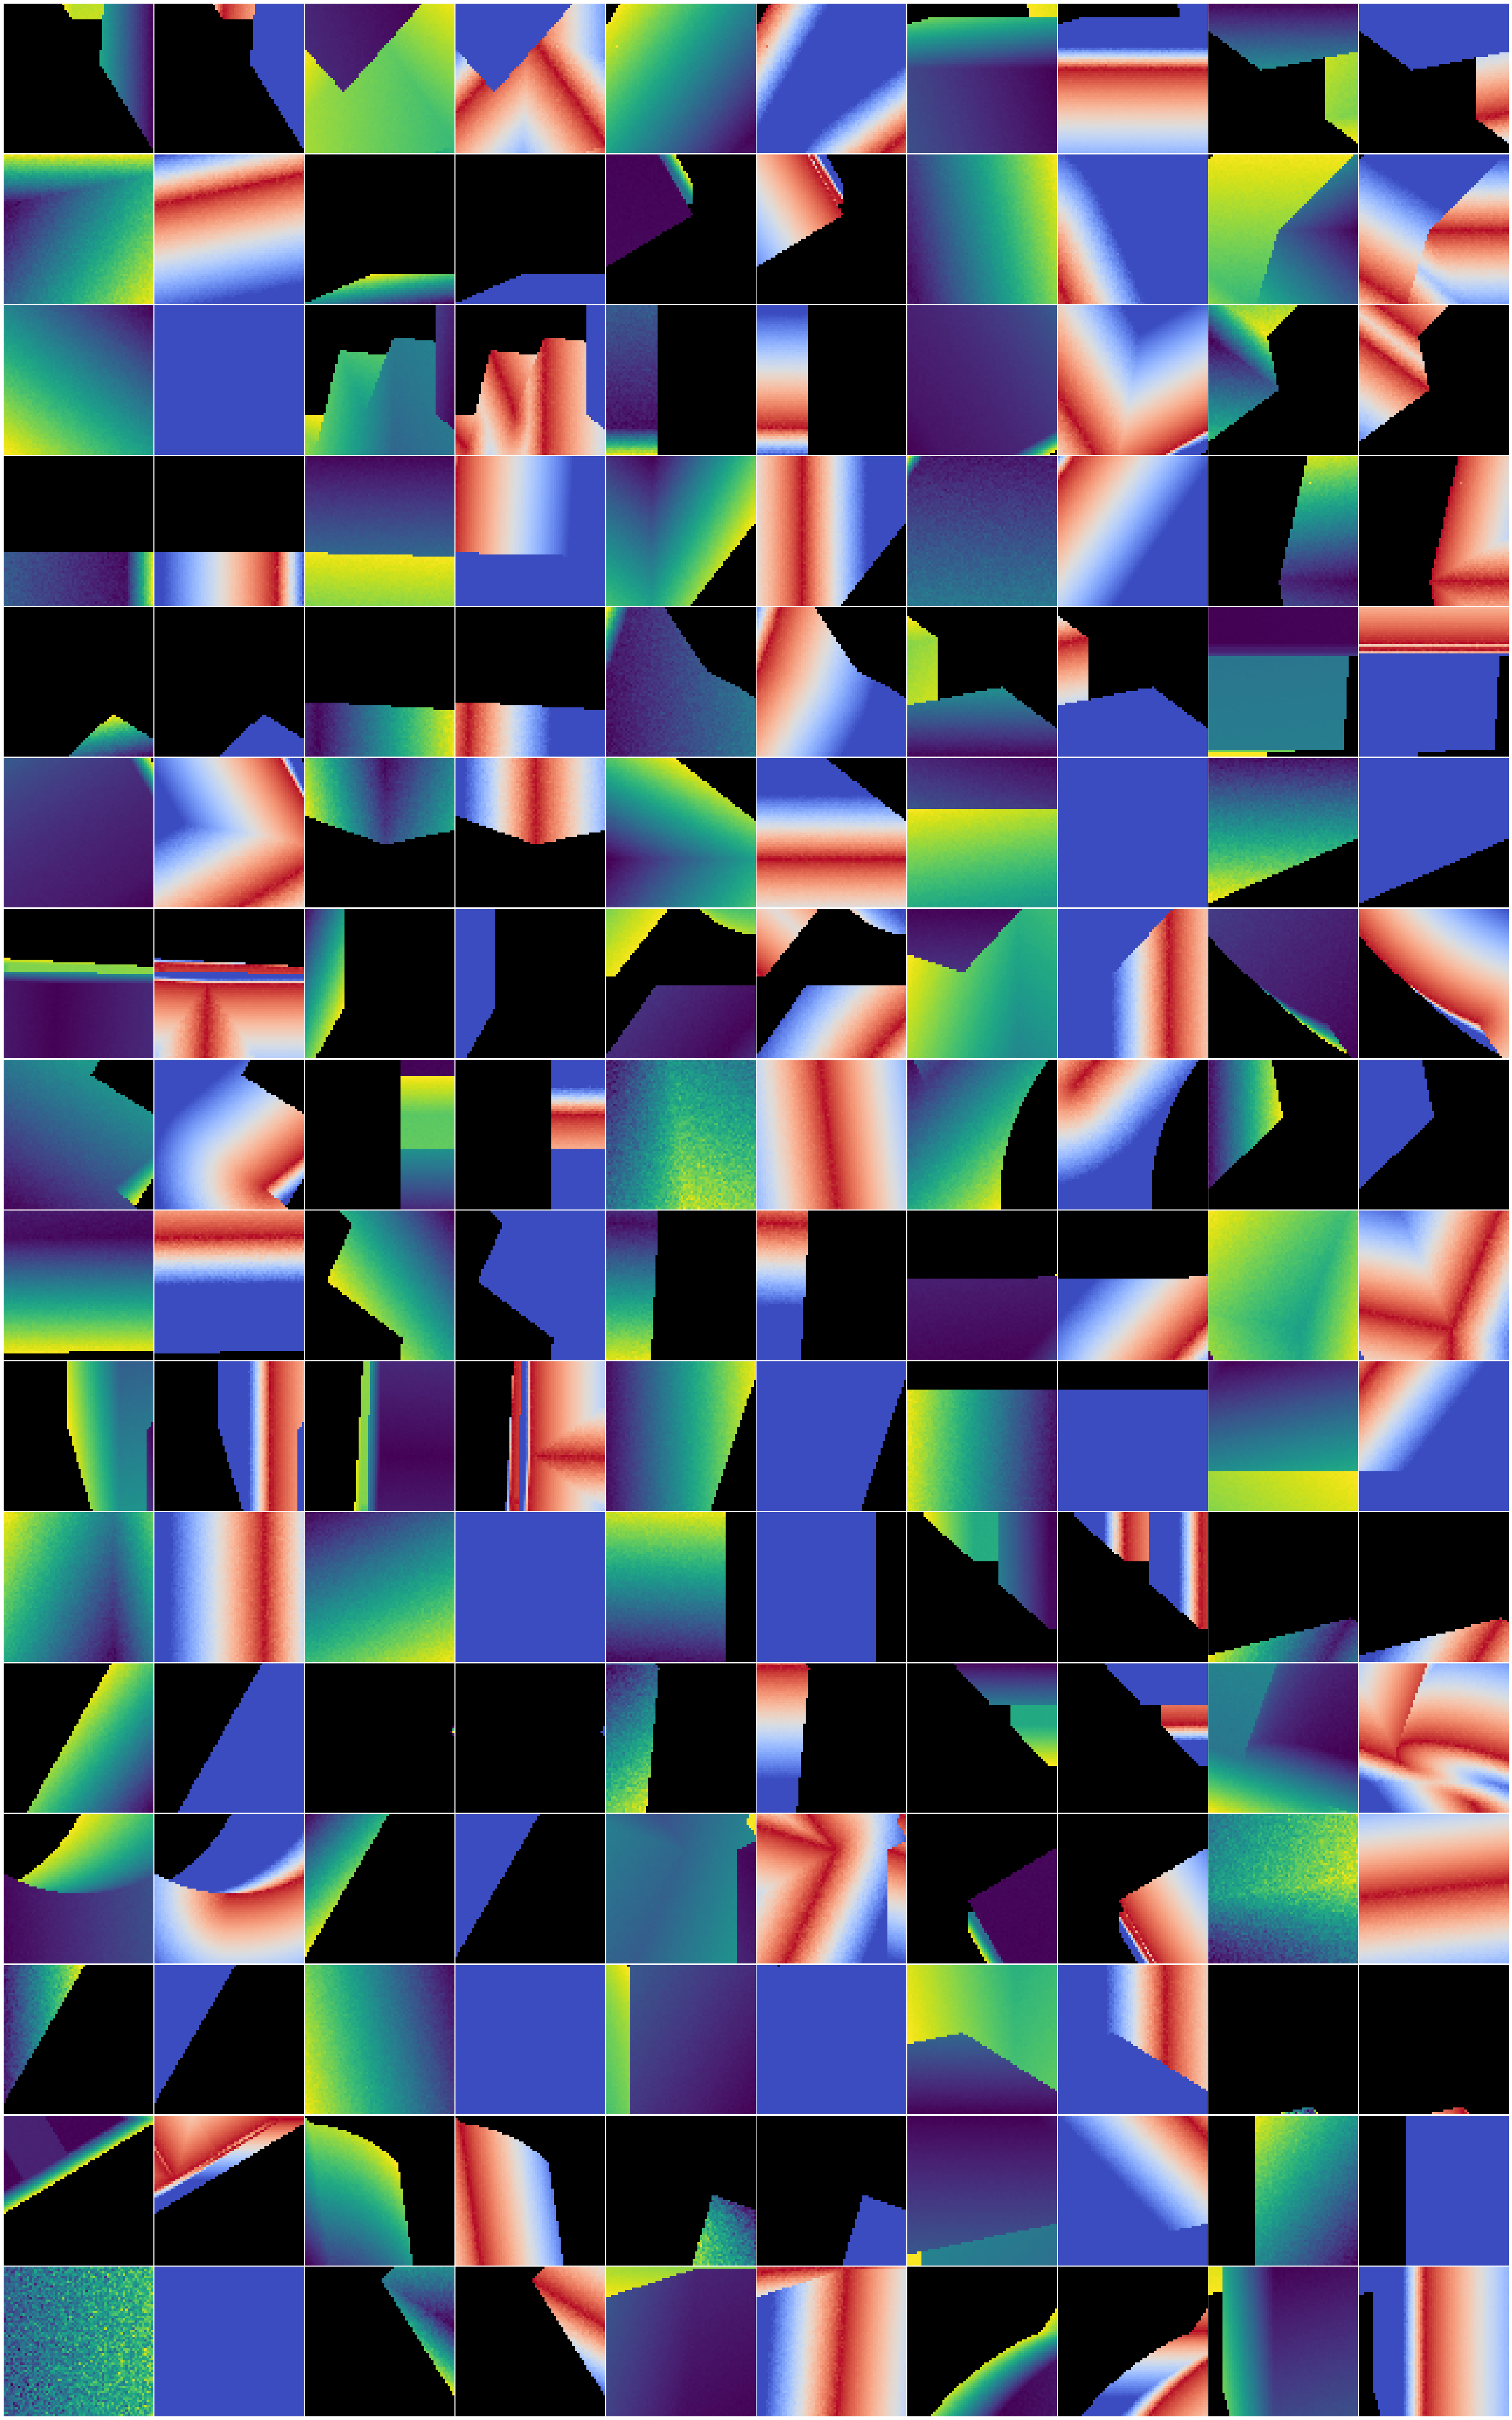

In [146]:
idx = np.random.choice(np.arange(len(images)), replace=False, size=80)

display_depth_sharpness(
    depth_images=images[idx],
    sharpness_images=distances[idx],
    axes_size=(4, 4),
    ncols=5
)

## Viewing depth images in 3D

In [147]:
import json
with open('/code/scripts/data_scripts/configs/depthmap_datasets/high_res.json') as config_file:
    config = json.load(config_file)

config

{'shape_fabrication_extent': 10.0,
 'short_curve_quantile': 0.25,
 'base_n_points_per_short_curve': 8,
 'base_resolution_3d': 0.125,
 'camera_pose': {'type': 'composite',
  'sequences': [{'type': 'sphere_to_origin', 'n_images': 36},
   {'type': 'xy_translation', 'n_images': 100},
   {'type': 'z_rotation', 'n_images': 5}]},
 'imaging': {'type': 'raycasting',
  'projection': 'ortho',
  'resolution_image': 64,
  'resolution_3d': 0.02,
  'fov': [115, 85, 80],
  'validate_image': True},
 'noise': {'type': 'many_noisers', 'subtype': 'z_direction', 'scale': [0.0]},
 'annotation': {'type': 'surface_based_aabb', 'distance_upper_bound': 1.0},
 'smell_coarse_surfaces_by_num_edges': {'num_edges_threshold': 8},
 'smell_coarse_surfaces_by_angles': {'max_angle_threshold_degrees': 10.0},
 'smell_deviating_resolution': {'resolution_3d': 0.02,
  'resolution_deviation_tolerance': 0.01},
 'smell_sharpness_discontinuities': {},
 'smell_bad_face_sampling': {'min_points_per_face': 0.02,
  'max_points_per_fac

In [148]:
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])

In [150]:
idx = np.random.choice(np.arange(len(images)))
# idx = 530
print(idx)

camera_pose = camera_poses[idx]
image = images[idx]
sharpness = distances[idx]

points = camera_pose.camera_to_world(imaging.image_to_points(image))

display_sharpness(
    None, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    samples=points, samples_psize=imaging.resolution_3d,
    samples_distances=sharpness[np.where(image != 0)]
)

384


Output()

## Dataloading with augmentations with DataLoader

In [73]:
# hdf5_input_dir = '/logs/points'
data_label = 'image'
target_label = 'distances'
# labels = ['directions', 'distances', 'has_sharp', 
#           'item_id', 'normals', 'num_sharp_curves', 
#           'num_surfaces', 'orig_face_indexes', 'orig_vert_indices', 'points']
# labels = '*'
# labels = ['points',
#           'num_sharp_curves', 
#           'num_surfaces',
#           'camera_pose']

# dataset = LotsOfHdf5Files(
#         data_dir=hdf5_input_dir,
#         io=DepthIO,
#         data_label=data_label,
#         target_label=target_label,
#         labels=labels,
#         max_loaded_files=10)

dataset = Hdf5File(
    '/logs/abc_0000_7130_7140.hdf5',
    io=DepthMapIO,
    data_label=data_label,
    target_label=target_label,
    labels=None,
    transform=None)
len(dataset)

3101

In [74]:
batch_size = 16
train_loader = DataLoader(
    dataset,
    num_workers=4,
    batch_size=batch_size,
    shuffle=False,
)

In [75]:
for batch in tqdm.tqdm(train_loader):
    pass

100%|██████████| 194/194 [00:00<00:00, 537.34it/s]
